### This notebook trains an EfficeintNet B4 model that treats the model as a multi classification problem. This approach did not work too well.
Since there are 5 classes, the network has 4 output nodes. If none of the nodes have a value higher than a threshold(0.5 in this case), the class is 0. If the first node has a value greater than threshold but the rest do not, the output is class 1. Similarly if first 2 nodes have value higher than threshold, the output is class 2. 
Note: Although it is not explicitly prevented, the network never gives invalid outputs. An invalid ouput would be where the network made non adjacent output nodes higher than threshold. For example only node 1 and node 4 having values higher than threshold would be an invalid output.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
import pandas as pd
import numpy as np
import cv2

from efficientnet_pytorch import EfficientNet

In [3]:
df = pd.read_csv('../Data/train_labels.csv').fillna('')#.iloc[:100,:]

In [6]:
old_stats = ([0.7229, 0.6502, 0.6050], [0.1622, 0.1431, 0.1128])
def get_data(size=224,bs=32):
    np.random.seed(420)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))
    
    data = (ImageList.from_df(df,'../Data/train_processed')
    .split_by_rand_pct(valid_pct=0.1)
    .label_from_df(cols='diagnosis')
    .transform(tfms, size=size)
    .databunch(bs=bs)).normalize(old_stats)
# #         ds_tfms=tfms,
# #         size=size,
# #         bs = bs,
# #         label_delim = ',',
# #         valid_pct = 0.1,
# #         num_workers = os.cpu_count() 
#     )#.normalize(old_stats)
    
    return data

In [7]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=5).cuda()
learn = Learner(get_data(448,16),
                model,
                wd=1e-5,
                callback_fns=[ShowGraph,
#                               OverSamplingCallback,
                              partial(SaveModelCallback, every='epoch', monitor='kappa_score', name='epoch'),
                              partial(SaveModelCallback, every='improvement', monitor='kappa_score', name='classification_best_kappa', mode='max'),
                              partial(AccumulateScheduler, n_step=2)
#                               partial(GradientAccumulator, num_iterations=2)
                             ],
                metrics=[accuracy,
                         KappaScore('quadratic')
                        ],
                loss_func=CrossEntropyFlat(reduction='sum')
               )
learn.to_fp16()
learn.mixup(alpha=0.15)
learn.load('/home/atom/Data/Old_data/train_processed/models/classification_best_kappa')
learn.unfreeze()

Loaded pretrained weights for efficientnet-b4


In [8]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B4_Class', res=224, bs=16, div=25):
#     learner.data = get_data(size=res,bs=bs)
#     learner.to_fp16()
#     learner.mixup(stack_y=False)
    learner.fit_one_cycle(epochs, lr, pct_start=0.3, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

## 416,416

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.793642,0.664647,0.785470,0.397008,28:35
1,0.665268,0.529984,0.829060,0.696810,28:56
2,0.609282,0.503658,0.835613,0.733986,28:43
3,0.667810,0.487891,0.840741,0.760211,28:35
4,0.601675,0.480377,0.843590,0.768718,28:38
5,0.614212,0.476317,0.845299,0.773294,29:42
6,0.634061,0.475714,0.846154,0.768680,30:49


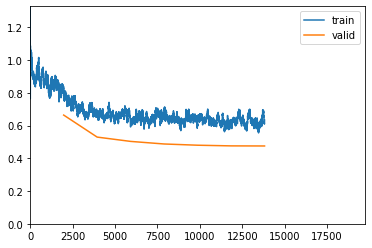

Better model found at epoch 0 with kappa_score value: 0.39700764417648315.
Better model found at epoch 1 with kappa_score value: 0.6968103051185608.
Better model found at epoch 2 with kappa_score value: 0.7339861989021301.
Better model found at epoch 3 with kappa_score value: 0.7602114677429199.
Better model found at epoch 4 with kappa_score value: 0.7687175273895264.
Better model found at epoch 5 with kappa_score value: 0.773293673992157.


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/mult

FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 319, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 194, in DupFd
    return resource_sharer.DupFd(fd)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocess

  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 356, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 126, in _sanitize_params
    dir = gettempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 294, in gettempdir
    tempdir = _get_default_tempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 236, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.

  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 76, in arbitrary_address
    return tempfile.mktemp(prefix='listener-', dir=util.get_temp_dir())
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/util.py", line 114, in get_temp_dir
    tempdir = tempfile.mkdtemp(prefix='pymp-')
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 356, in mkdtemp
    prefix, suffix, dir, output_type = _sanitize_params(prefix, suffix, dir)
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 126, in _sanitize_params
    dir = gettempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 294, in gettempdir
    tempdir = _get_default_tempdir()
  File "/anaconda3/envs/fastai/lib/python3.7/tempfile.py", line 229, in _get_default_tempdir
    dirlist)
FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/atom/models']


KeyboardInterrupt: 

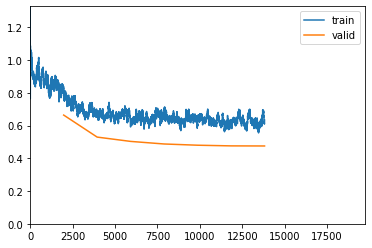

In [9]:
do_fit(learn, 10, 3e-5, res=448, bs=16)

Loaded epoch_6
Model classification_best_kappa_6 not found.


epoch,train_loss,valid_loss,accuracy,kappa_score,time
7,0.650326,0.473203,0.846154,0.774957,30:57
8,0.622692,0.473130,0.845584,0.772583,30:55
9,0.632574,0.473580,0.847009,0.776157,29:16


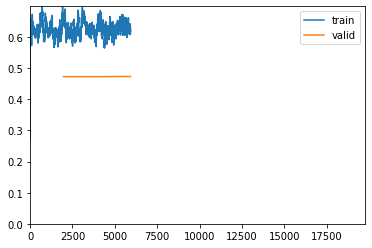

Better model found at epoch 7 with kappa_score value: 0.7749566435813904.
Better model found at epoch 9 with kappa_score value: 0.7761572599411011.
Model saved as B4_Class_448_17


In [7]:
do_fit(learn, 10, 3e-5, res=448, bs=16, start_epoch=7)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.127538,1.028078,0.642076,0.523971,04:16
1,1.123763,0.924605,0.707650,0.643013,04:06
2,1.101678,0.876471,0.715847,0.686333,04:06
3,1.012317,0.813024,0.732240,0.729281,04:06
4,0.944119,0.747812,0.734973,0.775482,04:05
5,0.873774,0.711223,0.743169,0.784809,04:00
6,0.924757,0.696355,0.743169,0.800539,04:00
7,0.859168,0.674118,0.756831,0.835304,04:02
8,0.834197,0.651542,0.767760,0.852560,04:02
9,0.877917,0.638536,0.767760,0.856622,04:01


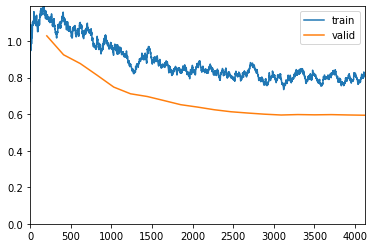

Better model found at epoch 0 with kappa_score value: 0.5239707827568054.
Better model found at epoch 1 with kappa_score value: 0.6430132389068604.
Better model found at epoch 2 with kappa_score value: 0.686333417892456.
Better model found at epoch 3 with kappa_score value: 0.7292805910110474.
Better model found at epoch 4 with kappa_score value: 0.7754820585250854.
Better model found at epoch 5 with kappa_score value: 0.7848086357116699.
Better model found at epoch 6 with kappa_score value: 0.8005385398864746.
Better model found at epoch 7 with kappa_score value: 0.8353041410446167.
Better model found at epoch 8 with kappa_score value: 0.852559506893158.
Better model found at epoch 9 with kappa_score value: 0.8566218614578247.
Better model found at epoch 11 with kappa_score value: 0.8641309142112732.
Better model found at epoch 13 with kappa_score value: 0.86460942029953.


RuntimeError: write(): fd 67 failed with No space left on device

In [10]:
do_fit(learn, 20, 3e-5, res=448, bs=16)

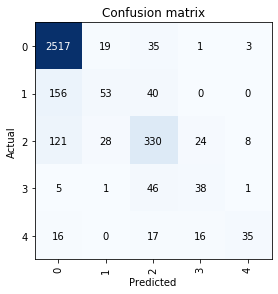

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
!sudo shutdown -h 1

In [ ]:
!sudo shutdown -c

In [15]:
gc.collect()

169